In [107]:
import random
from scipy.spatial import distance
import scipy.stats as sci
from eyeutil import *
from beh_utils import * 
import sys
import os.path
import pprint
import matplotlib.pyplot as plt
import scipy.io #MT

%matplotlib inline

target_sessions=[1]

#freiburg laptop resolution is 1920x1080
resX=1920
resY=1080

data_dir = "behavioral/"
subj_index=-1
subjects_id = ["300518"]
               #,"050918","120918"]

# subjects_id = ["CUBF40"]
print("total subject count: " + str(len(subjects_id)))
# subjects_id = ["300518"]
subj_saccade_total=np.zeros([len(subjects_id),1],dtype=int)
subj_saccade_distribution = np.zeros([40,len(subjects_id)],dtype=int)


#cross-population tallies
phase_saccade_count = np.zeros([12,1],dtype=int)
pop_sacc_start_times=np.zeros([0,1],dtype=int)
pop_sacc_end_times=np.zeros([0,1],dtype=int)

for subjects in subjects_id:
    total_sess=get_total_sess_count(subjects)
    print("total sessions: " + str(total_sess-1) + " for " + str(subjects))
    subj_samples=0
    subj_sacc_count=0
    #update the subj_index
    subj_index+=1
    #reset subj_saccade_total
    
    for i in target_sessions:
#     for i in range(1,2):
        zeroes_count=0
        velocityLeft=np.zeros([2000000,1],dtype=float)
        leftposX = np.zeros([2000000,1],dtype=float)
        leftposY = np.zeros([2000000,1],dtype=float)
        
        startTrialTime = np.zeros([40,1],dtype=int)
        endTrialTime = np.zeros([40,1],dtype=int)
        
        cortanaAvg = np.zeros([40,1],dtype=float)
        
        velocityRight=np.zeros([2000000,1],dtype=float)
        rightposX = np.zeros([2000000,1],dtype=float)
        rightposY = np.zeros([2000000,1],dtype=float)
        sess_id=i
        unique_samples=0
        unique_samples_left=0
        unique_samples_right=0
        times=np.zeros([2000000,1],dtype=int)
        leftTimes=np.zeros([2000000,1],dtype=int)
        rightTimes=np.zeros([2000000,1],dtype=int)
        timediff=-1
        trialindex=0
        logfile=data_dir+"sub"+subjects+"/session_"+str(i)+"/Beh/sub"+subjects+"Log.txt"
        print('logfile is',logfile)
#         logfile=data_dir+"sub240418/session_0/Beh/sub240418Log.txt"
        if os.path.isfile(logfile):
                    inFile = open(logfile)
                    for s in inFile.readlines():
                        s = s.replace('\r','8')
                        tokens = s[:-1].split('\t')
                        if len(tokens)>1:
                            phase=-999
                            latency = 0
                            if tokens[2]=="Trial Event":
                                phase_name=tokens[3][0:len(tokens[3])-1]
                                #remove _started or _ended markers
                                trimmed_phase_name=phase_name.replace('_ENDED','')
                                trimmed_phase_name=phase_name.replace('_STARTED','')
                                
                                if phase_name=="TRIAL_NAVIGATION_STARTED":
                                    startTrialTime[trialindex,0]=float(tokens[0])
                                if phase_name=="RECALL_PHASE_ENDED":
                                    itemindex=0
                                    endTrialTime[trialindex,0]=float(tokens[0])
                                    trialindex+=1
                                
                                    
                            if tokens[2]=="EYETRACKER_LATENCY": #out tobii eyetracker doesnt have latency probs take out
                                latency = int(tokens[3][0:len(tokens[3])-1])
                                if latency > 100000:
                                    latency = 0
                                else:
                                    latency = latency / 1000
#                                     print "latency is: " + str(latency)
                            if tokens[2]=="EYETRACKER_DISPLAY_POINT LEFT":
                                leftposX[unique_samples_left,0]= float(tokens[3])*resX
                                leftposY[unique_samples_left,0] = float (tokens[4])*resY
                                timestamp=int(tokens[0])
                                leftTimes[unique_samples_left,0]=timestamp - latency
                                unique_samples_left+=1
                            if tokens[2]=="EYETRACKER_DISPLAY_POINT RIGHT":
                                rightposX[unique_samples_right,0]= float(tokens[3])*resX
                                rightposY[unique_samples_right,0] = float (tokens[4])*resY
                                timestamp=int(tokens[0])
                                rightTimes[unique_samples_right,0]=timestamp - latency
                                unique_samples_right+=1

        for i in range(5,unique_samples_left-6):
            velocityLeft[i,0]=calculate_vel(leftposX,leftposY,i,unique_samples_left,leftTimes)
        for i in range(5, unique_samples_right-6):    
            velocityRight[i,0]=calculate_vel(rightposX,rightposY,i,unique_samples_right,rightTimes)



        #filter out saccade samples that cross the threshold velocity
        total=0
        mindistance=100
        current_dist=100
        prev_index=-1
        cleanVelLeft = velocityLeft[velocityLeft != 0] #only want times when eyes moving
        
        cleanVelRight = velocityRight[velocityRight != 0]
        print("orig threshleft: " + str(np.std(velocityLeft)))
        print("orig threshright: " + str(np.std(velocityRight)))
        print("threshold velocity left :" + str(np.std(cleanVelLeft)))
        print("threshold velocity right :" + str(np.std(cleanVelRight)))
        threshLeft=np.std(cleanVelLeft)
        threshRight=np.std(cleanVelRight)
        [sacc_Left,start_time_left,end_time_left] = calculate_saccades(velocityLeft,threshLeft,unique_samples_left,leftTimes)
        [sacc_Right,start_time_right,end_time_right] = calculate_saccades(velocityRight,threshRight,unique_samples_right,rightTimes)
        start_times_sacc = np.zeros([10000,1],dtype=int)
        end_times_sacc = np.zeros([10000,1],dtype=int)
        [bino_sacc_count,start_times_sacc,end_times_sacc] = calculate_binocular_saccades(start_time_left,end_time_left,start_time_right,end_time_right,sacc_Left,sacc_Right)
        print(start_times_sacc.shape)
        print(np.trim_zeros(start_times_sacc).shape)
        start_times=np.trim_zeros(start_times_sacc)
        end_times=np.trim_zeros(end_times_sacc)
        print(start_times.shape)
        #         subj_saccade_distribution[0:40,0:subj_index+1]=return_trial_saccade_distribution(start_times,startTrialTime,endTrialTime)
#         cortanaAvg = calculate_cortana_perf(cortanaPerf,totalCortana)
#         print calculate_spearman_correlation(subj_saccade_distribution[0:40,0:subj_index+1],cortanaAvg)[0]
#         corr_saccade_cortana_subj[sess_id,0]=calculate_spearman_correlation(subj_saccade_distribution[0:40,0:subj_index+1],cortanaAvg)[0]
        print("saccade count for left: " + str(sacc_Left) +" and for right: " + str(sacc_Right) + " for subject "+  str(subjects) + " session "+ str(sess_id))
        print("binocular saccade count: " + str(bino_sacc_count))
        subj_sacc_count+=bino_sacc_count
        pop_sacc_start_times=np.concatenate((pop_sacc_start_times,start_times),axis=None)
        pop_sacc_end_times=np.concatenate((pop_sacc_end_times,end_times),axis=None)
    subj_saccade_total[subj_index,0]=subj_sacc_count
    

total subject count: 1
total sessions: 0 for 300518
logfile is behavioral/sub300518/session_1/Beh/sub300518Log.txt
orig threshleft: 24.109629539869793
orig threshright: 26.677737761614463
threshold velocity left :83.53113791277377
threshold velocity right :98.28673249519797
(1560, 1)
(1560, 1)
(1560, 1)
saccade count for left: 1913 and for right: 1779 for subject 300518 session 1
binocular saccade count: 1560


In [2]:
print(subj_saccade_total)

[[1560]]


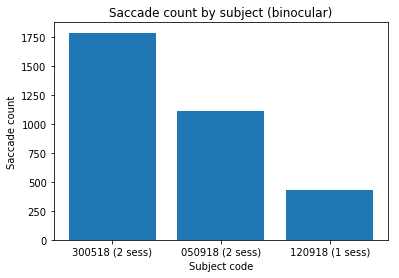

In [4]:
fig,ax=plt.subplots() 
ax.bar(np.arange(0,len(subjects_id),1),subj_saccade_total[:,0]) 
ax.xaxis.set_ticks(np.arange(0,len(subjects_id),1))

ax.xaxis.set_ticklabels(["300518 (2 sess)", "050918 (2 sess)", "120918 (1 sess)"]) 
ax.xaxis.set_label_text('Subject code') 
ax.yaxis.set_label_text('Saccade count')

plt.title('Saccade count by subject (binocular)') 
plt.show()


In [120]:
# print(pop_sacc_start_times[0:300])
print(pop_sacc_start_times[220])
print(pop_sacc_start_times[250])

ix=np.isin(pop_sacc_start_times,1527840361412)
print(pop_sacc_start_times[np.logical_and(pop_sacc_start_times>=1527664752996, pop_sacc_start_times <= 1527664752998)].shape[0]>0)


1527840361493
1527840361500
False


In [121]:

phase_name_dict={1:'INSTRUCTION_VIDEO', 2:'HOMEBASE_TRANSPORT', 3:'TRIAL_NAVIGATION',4:'PLAYER_CHEST_ROTATION',
            5:'TOWER_TRANSPORT',6:'DISTRACTOR_GAME',7:'RECALL_PHASE',8:'LOCATION_RECALL_CHOICE',
            9:'TEMPORAL_RETRIEVAL',10:'FEEDBACK',11:'SCORESCREEN',12:'BLOCKSCREEN',13:'TEMPORAL_FEEDBACK',14:'OBJECT_RECALL_CHOICE'}

# for i in range(0,14):
#     print(str(phase_saccade_count[i,0]) + " in " + str(phase_name_dict[i+1]))

In [122]:
data_dir = "behavioral/"
subj_index=-1
subjects_id = ["300518"]
               #,"050918","120918"]

#cross-population tallies

left_display=np.zeros([150000,28],dtype=float)
right_display=np.zeros([150000,28],dtype=float)

left_virtual=np.zeros([150000,28],dtype=float)
right_virtual=np.zeros([150000,28],dtype=float)

phase_saccade_count = np.zeros([14,1],dtype=int)
phase_times = np.zeros([14,2],dtype=int)
ignore_phase={'RECALL_SPECIAL','SHOWING_INSTRUCTIONS','SPHINX_EVENT','TASK_PAUSED'}

currIndex=0
leftIndex=0
rightIndex=0

left_v_index=0
right_v_index=0
trial_began=False
phase_index=0

for subjects in subjects_id:
    total_sess=get_total_sess_count(subjects)
    print("total sessions: " + str(total_sess-1) + " for " + str(subjects))
    subj_samples=0
    subj_sacc_count=0
    prevLength=0
    #update the subj_index
    subj_index+=1
    
    for i in target_sessions:
        starting_ts=0
        ending_ts=0
        sess_id=i
        logfile=data_dir+"sub"+subjects+"/session_"+str(i)+"/Beh/sub"+subjects+"Log.txt"
        print(logfile)
        print("starting new trial")
        if os.path.isfile(logfile):
                    inFile = open(logfile)
                    for s in inFile.readlines():
                        s = s.replace('\r','8')
                        tokens = s[:-1].split('\t')
                        if len(tokens)>1:
                            phase=-999
                            latency = 0
                            if currIndex<pop_sacc_start_times.shape[0]:
                                if trial_began and int(tokens[0])>=pop_sacc_start_times[currIndex] and int(tokens[0]) <=pop_sacc_end_times[currIndex]:
                                    if tokens[2]=="EYETRACKER_DISPLAY_POINT LEFT":
                                        left_display[leftIndex,(phase_index-1)*2]=float(tokens[3])
                                        left_display[leftIndex,((phase_index-1)*2)+1]=float(tokens[4])
                                        leftIndex+=1
                                    if tokens[2]=="EYETRACKER_DISPLAY_POINT RIGHT":
                                        right_display[rightIndex,(phase_index-1)*2]=float(tokens[3])
                                        right_display[rightIndex,((phase_index-1)*2)+1]=float(tokens[4])
                                        rightIndex+=1
                                    if tokens[2]=="EYETRACKER_VIRTUAL_POINT LEFT":
                                        #print("ADDED VIRTUAL LEFT POINT")
                                        left_virtual[left_v_index,(phase_index-1)*2]=float(tokens[3])
                                        left_virtual[left_v_index,((phase_index-1)*2)+1]=float(tokens[5])
                                        left_v_index+=1
                                    if tokens[2]=="EYETRACKER_VIRTUAL_POINT RIGHT":
                                        #print("ADDED VIRTUAL RIGHT POINT")
                                        right_virtual[right_v_index,(phase_index-1)*2]=float(tokens[3])
                                        right_virtual[right_v_index,((phase_index-1)*2)+1]=float(tokens[5])
                                        right_v_index+=1
                                if int(tokens[0]) >= pop_sacc_end_times[currIndex]:
                                    diff=leftIndex-prevLength
                                    prevLength=leftIndex
    #                                 print("updated currindex")
                                    currIndex+=1
                                
                                
                            if tokens[2]=="Trial Event":
                                if tokens[3]=="SHOWING_INSTRUCTIONS":
                                    if not trial_began:
                                        trial_began=True
                                phase_name=tokens[3][0:len(tokens[3])]
#                                 print("og " + str(phase_name))
                                phase_index=0
                                if phase_name not in ignore_phase:
                                    phase_index=return_phase_index(phase_name)
                                    if("STARTED" in phase_name):
#                                         print("starting " +str(phase_name))
                                        phase_times[phase_index-1,0]=int(tokens[0])
                                    elif("ENDED" in phase_name):
#                                         print("ending " + str(phase_name))
                                        phase_times[phase_index-1,1]=int(tokens[0])
#                                         print("between " + str(phase_times[phase_index-1,0]) + " and " + str(phase_times[phase_index-1,1]))
                                        phase_saccs=pop_sacc_start_times[np.logical_and(pop_sacc_start_times>=phase_times[phase_index-1,0], pop_sacc_start_times <= phase_times[phase_index-1,1])].shape[0]
                                        if phase_saccs > 0:
                                            print("adding " + str(phase_saccs) + " into total count for " + str(phase_name_dict[phase_index]))
                                            phase_saccade_count[phase_index-1,0]+=phase_saccs
                            
                                

total sessions: 0 for 300518
behavioral/sub300518/session_1/Beh/sub300518Log.txt
starting new trial
adding 16 into total count for TRIAL_NAVIGATION
adding 2 into total count for TOWER_TRANSPORT
adding 3 into total count for OBJECT_RECALL_CHOICE
adding 3 into total count for TEMPORAL_RETRIEVAL
adding 6 into total count for RECALL_PHASE
adding 12 into total count for LOCATION_RECALL_CHOICE
adding 3 into total count for TEMPORAL_RETRIEVAL
adding 15 into total count for RECALL_PHASE
adding 5 into total count for FEEDBACK
adding 5 into total count for TRIAL_NAVIGATION
adding 8 into total count for DISTRACTOR_GAME
adding 3 into total count for TRIAL_NAVIGATION
adding 7 into total count for DISTRACTOR_GAME
adding 1 into total count for DISTRACTOR_GAME
adding 19 into total count for TEMPORAL_RETRIEVAL
adding 19 into total count for RECALL_PHASE
adding 3 into total count for TRIAL_NAVIGATION
adding 4 into total count for SCORESCREEN
adding 4 into total count for FEEDBACK
adding 11 into total co

In [3]:
phase_name="INSTRUCTION_VIDEO_STARTED"
phase_name=phase_name.replace('_ENDED','')
phase_name=phase_name.replace('_STARTED','')
print(phase_name)

INSTRUCTION_VIDEO


1527840361486


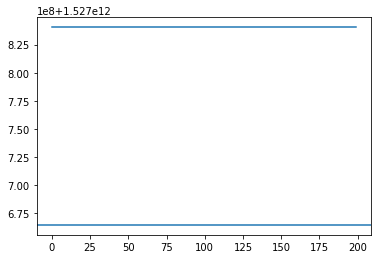

In [8]:
plt.plot(pop_sacc_start_times[0:200])
print(pop_sacc_start_times[200])
plt.axhline(1527664753000)
#1527664752996
# plt.axvline(1527665198443)
plt.show()

In [14]:
idx=phase_saccade_count[:,0]>40
chosen_idx=np.where(idx)[0]
print(chosen_idx)
# plt.bar(phase_saccade_count[chosen_idx,0])

[2 6 7 9]


TRIAL_NAVIGATION
RECALL_PHASE
LOCATION_RECALL_CHOICE
FEEDBACK


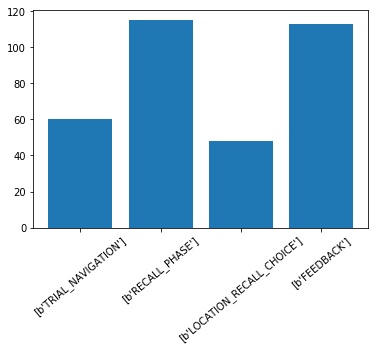

In [69]:
fig,ax=plt.subplots()
ax.bar(np.arange(0,len(chosen_idx),1),phase_saccade_count[chosen_idx,0])
ax.xaxis.set_ticks(np.arange(0,len(chosen_idx),1))

label_names=np.empty([len(chosen_idx),1],dtype='S40')
for i in range(0,len(chosen_idx)):
    print(phase_name_dict[chosen_idx[i]+1])
    label_names[i,0]=phase_name_dict[chosen_idx[i]+1]
    
ax.xaxis.set_ticklabels(label_names)
plt.xticks(rotation=40)
plt.show()

In [70]:
print(phase_saccade_count)

[[  0]
 [  5]
 [ 60]
 [  0]
 [  5]
 [ 34]
 [115]
 [ 48]
 [ 40]
 [113]
 [ 34]
 [  9]
 [  7]
 [  3]]


In [17]:
left_display_x = np.zeros([])
for i in range(0,14):
    left_display_x=np.trim_zeros(left_display[:,(i*2)])
    left_display_y=np.trim_zeros(left_display[:,(i*2)+1])

    right_display_x=np.trim_zeros(right_display[:,i*2])
    right_display_y=np.trim_zeros(right_display[:,(i*2)+1])

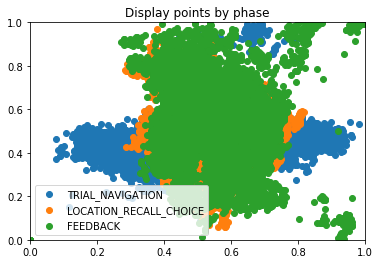

In [71]:
target_idx = [2,6,7,9]
for i in target_idx:
    plt.scatter(np.trim_zeros(left_display[:,(i*2)]),np.trim_zeros(left_display[:,(i*2)+1]),label=str(phase_name_dict[i+1]))
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Display points by phase")
plt.legend(loc=0)
plt.show()

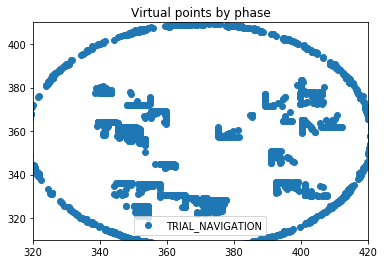

In [107]:
target_idx = [2]
for i in target_idx:
    plt.scatter(np.trim_zeros(left_virtual[:,(i*2)]),np.trim_zeros(left_virtual[:,(i*2)+1]),label=str(phase_name_dict[i+1]))

plt.xlim(320,420)
plt.ylim(310,410)
plt.title("Virtual points by phase")
plt.legend(loc=0)
plt.show()

FEEDBACK


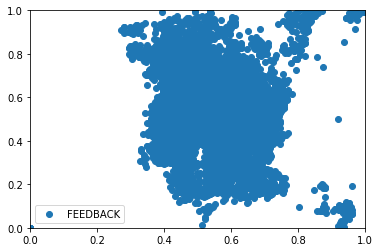

In [47]:
chosen_phase_idx=9
print(phase_name_dict[chosen_phase_idx+1])
plt.scatter(np.trim_zeros(left_display[:,(chosen_phase_idx*2)]),np.trim_zeros(left_display[:,(chosen_phase_idx*2)+1]),label=str(phase_name_dict[chosen_phase_idx+1]))
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=0)
plt.show()

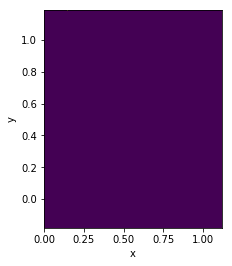

In [58]:
heatmap, xedges, yedges = np.histogram2d(np.trim_zeros(left_display[:,(chosen_phase_idx*2)]),
np.trim_zeros(left_display[:,(chosen_phase_idx*2)+1]),bins=(313,313))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plot heatmap
plt.clf()
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap,extent=extent)
plt.show()

chosen idx 2
chosen idx 7
chosen idx 9


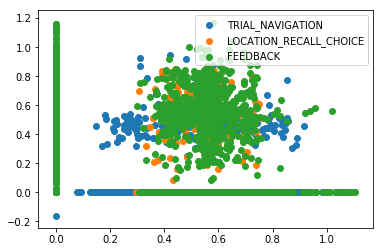

In [59]:
sampling_freq=5
for i in chosen_idx:
    if i !=6:
        print("chosen idx " + str(i))
        left_x=np.trim_zeros(left_display[:,(i*2)])
        sampled_lx= np.random.choice(left_x,int(left_x.shape[0]/sampling_freq))
        left_y=np.trim_zeros(left_display[:,(i*2)+1])
        sampled_ly= np.random.choice(left_y,int(left_y.shape[0]/sampling_freq))
        plt.scatter(sampled_lx,sampled_ly,label=str(phase_name_dict[i+1]))
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.legend(loc=0)
plt.show()

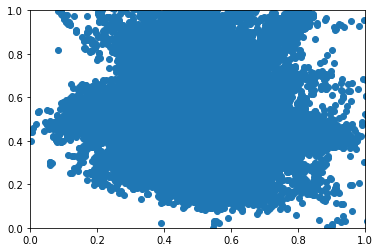

In [9]:
plt.scatter(right_display_x,right_display_y)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

150000


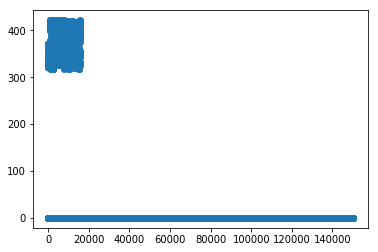

In [99]:
print(right_virtual.shape[0])
plt.scatter(np.arange(0,150000),right_virtual[:,4])
plt.show()

(1560, 2)
Ttest_relResult(statistic=-5.963905884216679, pvalue=3.041277514786749e-09)


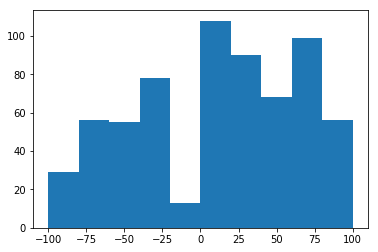

(array([ 29,  56,  55,  78,  13, 108,  90,  68,  99,  56]), array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.,
         80.,  100.]))
[0.37179487 0.71794872 0.70512821 1.         0.16666667 1.38461538
 1.15384615 0.87179487 1.26923077 0.71794872]


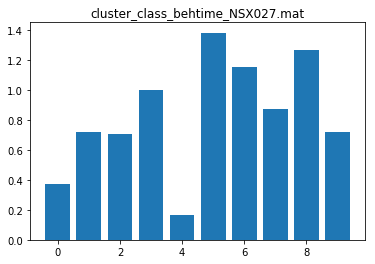

In [325]:
sorted_path = 'clusters/20180601_THG_1/'
all_sorted = os.listdir(sorted_path)
all_sorted.pop(0) #first element isn't mat file so take out
 

all_sorted = ['cluster_class_behtime_NSX027.mat']
for c in all_sorted: #for each channel
    clusters = scipy.io.loadmat('clusters/20180601_THG_1/'+c)
        
    #clusters = scipy.io.loadmat('clusters/20180601_THG_1/cluster_class_behtime_NSX004.mat')
    clusters_spktimes = clusters['cluster_class_behtime']
    clustLabels = []
    spkTimes = []

    for row in clusters_spktimes:
        clustLabels=np.append(clustLabels,row[0])
        spkTimes=np.append(spkTimes,row[2])
    uniqueClusters = np.unique(clustLabels)
    uniqueClusters = uniqueClusters[np.logical_not(np.isnan(uniqueClusters))] #take out nans
    uniqueClusters[uniqueClusters != 0] #also take out 0's (clusterclass 0 not a unit)

#     print('clusters/20180601_THG_1/'+c)
#     print(uniqueClusters.shape)
    for clust in uniqueClusters:
        #get all indices for the cluster and get all its spike times
        clust_idx = np.where(clustLabels == clust)
        clust_spkTimes = spkTimes[clust_idx]
        clust_spkTimes = clust_spkTimes * 1000 #convert from s to ms
#         plt.scatter(np.arange(0,clust_spkTimes.shape[0]),clust_spkTimes)
#         plt.show()
        
        #for each saccade start time see if there are spikes from -500:500 ms
        #range_around_sacc = np.arange(-500,500,100)
        all_sacc_starts = pop_sacc_start_times
        #spks_around_saccade = np.zeros([all_sacc_starts.shape[0],range_around_sacc.shape[0]])

#         print(pop_sacc_end_times-pop_sacc_start_times)
        
        range_around_sacc = 100
        spks_around_saccade = []
        spks_around_each_saccade = np.zeros([len(all_sacc_starts),2])
        saccCount = 0
        aroundSacc = 10
        for saccade in all_sacc_starts:
            tmp = clust_spkTimes[np.logical_and(clust_spkTimes >= saccade-range_around_sacc, clust_spkTimes <= saccade + range_around_sacc)]

            befSac = clust_spkTimes[np.logical_and(clust_spkTimes >= saccade-aroundSacc, clust_spkTimes < saccade)]
            aftSac = clust_spkTimes[np.logical_and(clust_spkTimes >= saccade, clust_spkTimes < saccade + aroundSacc)]
                  
            spks_around_each_saccade[saccCount,0] = befSac.shape[0]/(aroundSacc/1000)
            spks_around_each_saccade[saccCount,1] = aftSac.shape[0]/(aroundSacc/1000)
#             print(spks_around_each_saccade[saccCount,:])
            saccCount += 1
            
            #print(min(abs(clust_spkTimes - saccade)))
            if tmp.shape[0]>0:
                spks_around_saccade = np.append(spks_around_saccade,tmp-saccade)
                #print(tmp.shape)
        print(spks_around_each_saccade.shape)
        print(sci.ttest_rel(spks_around_each_saccade[:,0],spks_around_each_saccade[:,1]))
        
        numBins = int((range_around_sacc*2)/20)

        myhist = np.histogram(spks_around_saccade,numBins, range = (-1*range_around_sacc, range_around_sacc))
        
        plt.hist(spks_around_saccade,numBins,range = (-1*range_around_sacc, range_around_sacc))
        plt.show()
        
        print(myhist)
        FR = myhist[0]/(all_sacc_starts.shape[0]*0.05)
        print(FR)
        plt.bar(np.arange(0,numBins,1),FR)
        plt.title(c)
        plt.show()
        
    
    #print(spks_around_saccade)
    
    

-56.7360033976237
-35.375083333333336
-3.2083048095703126
18.15261525472005


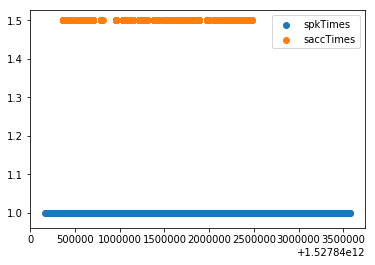

In [257]:
# print((clust_spkTimes[0]-clust_spkTimes[-1])/60000)
# print((pop_sacc_start_times[0]-pop_sacc_start_times[-1])/60000)

print((clust_spkTimes[0]-pop_sacc_start_times[0])/60000)
print((clust_spkTimes[-1]-pop_sacc_start_times[-1])/60000)

plt.scatter(clust_spkTimes,np.zeros(clust_spkTimes.shape[0])+1, label='spkTimes')
plt.scatter(pop_sacc_start_times,np.zeros(pop_sacc_start_times.shape[0])+1.5, label='saccTimes')
plt.legend()
plt.show()

In [291]:
print(np.arange(-50,50,10))

[-50 -40 -30 -20 -10   0  10  20  30  40]
